### Configuración Inicial

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importamos todos los módulos que se van a utilizar y definimos funciones generales que se usan en distintas partes del trabajo.

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sklearn as sk
from sklearn.model_selection import (
    train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest


dataset = pd.read_csv("/content/drive/MyDrive/orga/properati_argentina_2021.csv")

SEMILLA = 0
TEST_SIZE = 0.2


# 1. Análisis Exploratorio y Preprocesamiento de Datos


## Separación Train-Test

En primer lugar separamos el dataset con el que se va a trabajar en dos: el 80% se utilizará para entrenar a los modelos y el 20% para testear que los modelos estén funcionando como se espera.

Se realiza la separación antes de comenzar a trabajar los datos para que durante la etapa de entrenamiento no haya conocimiento sobre los datos que luego se usarán para testear y así pueda predecir de forma adecuada.

In [64]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=TEST_SIZE, random_state=SEMILLA
)

print("Proporción - Train: {:.2f}".format(dataset_train.shape[0] / dataset.shape[0]))
print("Proporción - Test: {:.2f}".format(dataset_test.shape[0] / dataset.shape[0]))


Proporción - Train: 0.80
Proporción - Test: 0.20


## Filtrado del set de Training

Damos un primer vistazo al dataset, para observar las columnas y sus valores.

In [65]:
dataset_train.head(5)


,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
19012,f19OtftrEdr1twkOwQdmIw==,2021-01-27,2021-07-01,2021-01-27,NaN,NaN,Bs.As. G.B.A. Zona Norte,NaN,NaN,NaN,NaN,Venta,Casa,7.0,5.0,269.0,269.0,380000.0,USD,Casa - Zarate
418309,Ak3A3BAUvl8vjWRpGdMSqg==,2021-10-14,2021-11-03,2021-10-14,-34.400856,-58.649901,Bs.As. G.B.A. Zona Norte,Tigre,Nordelta,NaN,NaN,Venta,Departamento,3.0,2.0,95.0,88.0,170000.0,USD,DEPARTAMENTO VENTA ANTARES NORDELTA 3 AMBIENTE...
157888,K8U3zUGHru2nNfFhsz8ckA==,2021-05-26,2021-06-27,2021-05-26,-32.891939,-68.854564,Mendoza,Mendoza,NaN,NaN,NaN,Alquiler,Departamento,2.0,1.0,120.0,60.0,28500.0,ARS,"Alquiler DEPARTAMENTO en Ciudad, a mts Aristides"
405630,ZauA5QYZtApfKQkF5gIu+A==,2021-01-07,2021-09-03,2021-01-07,-34.895556,-57.977944,Bs.As. G.B.A. Zona Sur,La Plata,Tolosa,NaN,NaN,Venta,Casa,5.0,3.0,85.0,85.0,110000.0,USD,Duplex venta 3 dormitorios 2 baños 1 cochera 8...
147192,Cvf0fa9tdZflz/jma3g2Kw==,2021-08-19,2021-10-14,2021-08-19,-34.900083,-56.171641,Montevideo,NaN,NaN,NaN,NaN,Alquiler,Departamento,NaN,1.0,55.0,45.0,19900.0,UYU,Apartamento de 1 dormitorio en ALQUILER - Cordón


Definimos un diccionario de filtros que vamos a utilizar para filtrar nuestro dataset, y filtramos las columnas que no nos interesan; antes de filtrarlas, normalizamos sus valores por si hay alguna discrepancia (to lowercase).

In [66]:
filtro_tipo_propiedad = ["casa", "ph", "departamento"]
filtro_operacion = ["venta"]
filtro_ubicacion = ["capital federal"]
filtro_moneda = ["usd"]

filtros = {
    "property_type": filtro_tipo_propiedad,
    "operation": filtro_operacion,
    "place_l2": filtro_ubicacion,
    "property_currency": filtro_moneda,
}


def filtrado_columnas(dataset):
    for columna in filtros:
        dataset[columna] = dataset[columna].str.lower()

    for columna_a_filtrar, filtro in filtros.items():
        dataset = dataset[dataset[columna_a_filtrar].isin(filtro)]

    return dataset


dataset_train = filtrado_columnas(dataset_train)
dataset_test = filtrado_columnas(dataset_test)

dataset_train.shape


(75488, 20)

Observamos la proporción de datos NULL en las columnas del dataset.

In [67]:
filas_totales = dataset_train.shape[0]
proporcion_null = dataset_train.isna().sum() / filas_totales * 100
proporcion_null.sort_values(ascending=False, inplace=True)
proporcion_null


place_l6                    100.000000
place_l5                    100.000000
place_l4                     96.131836
property_bedrooms            11.532959
property_surface_total        5.129292
latitud                       3.972817
longitud                      3.972817
property_surface_covered      3.572753
property_rooms                1.092889
place_l3                      0.435831
property_currency             0.000000
property_price                0.000000
id                            0.000000
property_type                 0.000000
operation                     0.000000
start_date                    0.000000
place_l2                      0.000000
created_on                    0.000000
end_date                      0.000000
property_title                0.000000
dtype: float64

Vemos que las columnas `place_l5` y `place_l6` contienen `NaN` en todas sus filas y `place_4` contiene `NaN` en el 96% de sus filas. Por estas razones, eliminamos las columnas.

Las columnas `id` y `property_title` no nos sirven para predecir nada, ya que son valores arbitrarios que no aportan al análisis. Por lo que también las eliminamos.

Luego, debido al filtrado realizado previamente, las columnas `property_currency`, `place_l2`, `operation` contienen un solo valor posible, por lo que también las eliminamos ya que no aportan información extra al análisis.

En este trabajo, no vamos a analizar las variables temporales, por lo que también podemos retirar esas columnas del dataset



In [68]:
columnas_eliminar = [
    "property_title",
    "id",
    "place_l4",
    "place_l5",
    "place_l6",
    "property_currency",
    "operation",
    "place_l2",
    "start_date",
    "end_date",
    "created_on"
]


def eliminar_columnas(dataset, columnas_eliminar):
    dataset.drop(columnas_eliminar, axis=1, inplace=True)
    return dataset


dataset_train = eliminar_columnas(dataset_train, columnas_eliminar)
dataset_test = eliminar_columnas(dataset_test, columnas_eliminar)


Como `place_l3` no es un nombre muy significativo, lo renombramos a `barrio` y estandarizamos la columna, seteando los datos invalidos a None.

In [69]:
dataset_train = dataset_train.rename(columns={"place_l3": "barrio"})
dataset_train["barrio"] = dataset_train["barrio"].apply(
    lambda barrio: barrio if type(barrio) == str else None
)

dataset_test = dataset_test.rename(columns={"place_l3": "barrio"})
dataset_test["barrio"] = dataset_test["barrio"].apply(
    lambda barrio: barrio if type(barrio) == str else None
)


Como carecen de sentido, seteamos a NULL aquellos valores de `property_surface_total` y `property_surface_covered` que valgan menos de 30, ya que bastanta menor al tamaño promedio de los monoambientes (propiedad más chica posible).

In [70]:
def setear_null_superficie(fila):
    if fila["property_surface_total"] < 30:
        fila["property_surface_total"] = np.nan
    if fila["property_surface_covered"] < 30:
        fila["property_surface_covered"] = np.nan

    return fila


dataset_train = dataset_train.apply(setear_null_superficie, axis=1)
dataset_test = dataset_test.apply(setear_null_superficie, axis=1)


 ## Análisis de Valores Atípicos Univariados

Primero realizamos un **BOXPLOT** de las variables cuantitativas para observar de forma rápida la distribución de _outliers univariados_.

In [71]:
columnas_cuantitativas = ["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_price"]
variables_cuantitativas = dataset_train[columnas_cuantitativas]

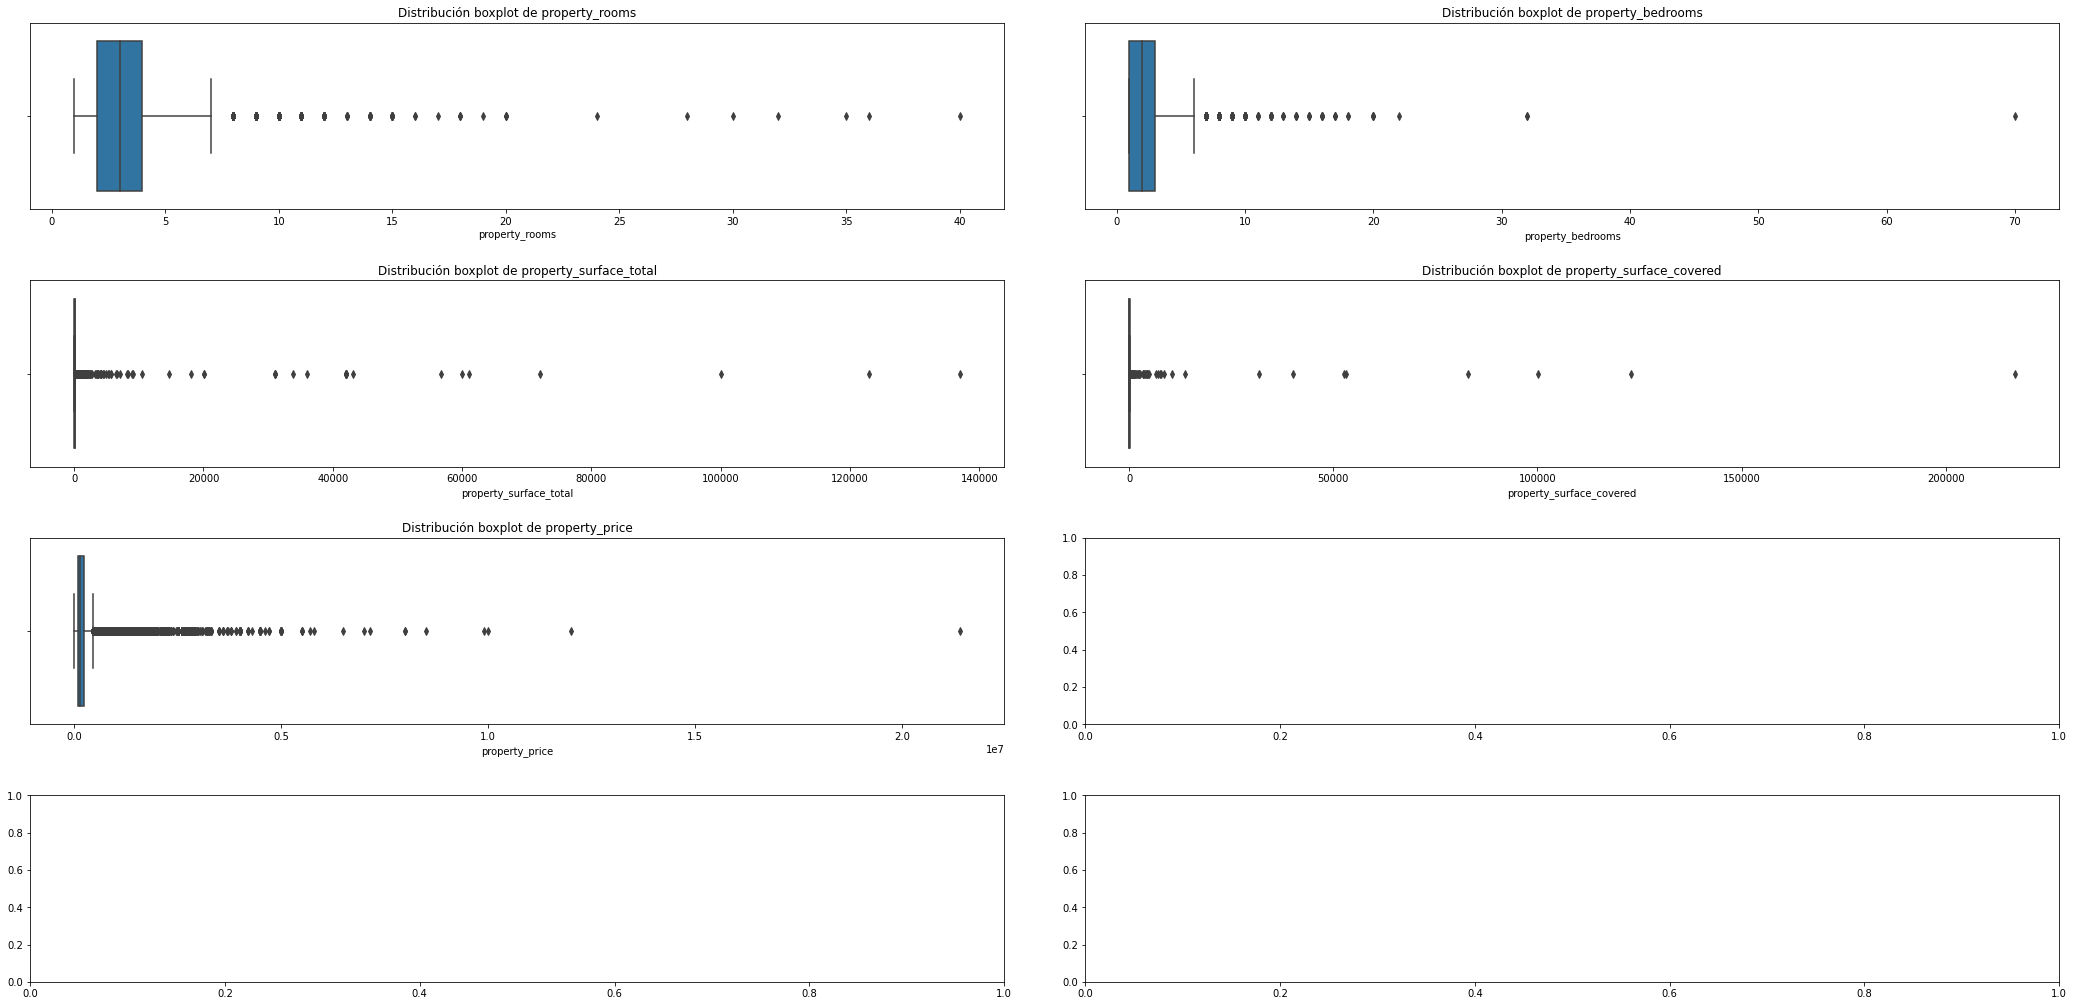

In [72]:
figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
figs.tight_layout(pad=5)
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico = sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)
    grafico.set(title=f"Distribución boxplot de {columna}")


Observamos que quedan muchos valores que se salen del rango intercuartil, por lo que podemos eliminar aquellos que quedan fuera de: rango intercuartil * 3; es decir, los outliers univariados severos.

In [73]:
for columna in variables_cuantitativas.columns:
    columna_q1 = dataset_train[columna].quantile(0.25)
    columna_q3 = dataset_train[columna].quantile(0.75)
    iqr = columna_q3 - columna_q1

    lim_superior = columna_q3 + 3 * iqr
    lim_inferior = columna_q1 - 3 * iqr

    filtro_columna = (dataset_train[columna] >= lim_superior) | (
        dataset_train[columna] <= lim_inferior
    )
    indices = dataset_train[filtro_columna].index
    dataset_train.drop(index=indices, inplace=True)

    filtro_columna_test = (dataset_test[columna] >= lim_superior) | (
        dataset_test[columna] <= lim_inferior
    )
    indices_test = dataset_test[filtro_columna_test].index
    dataset_test.drop(index=indices_test, inplace=True)


Al realizar nuevamente el **BOXPLOT**, observamos que la distribuciones son mucho más uniformes.

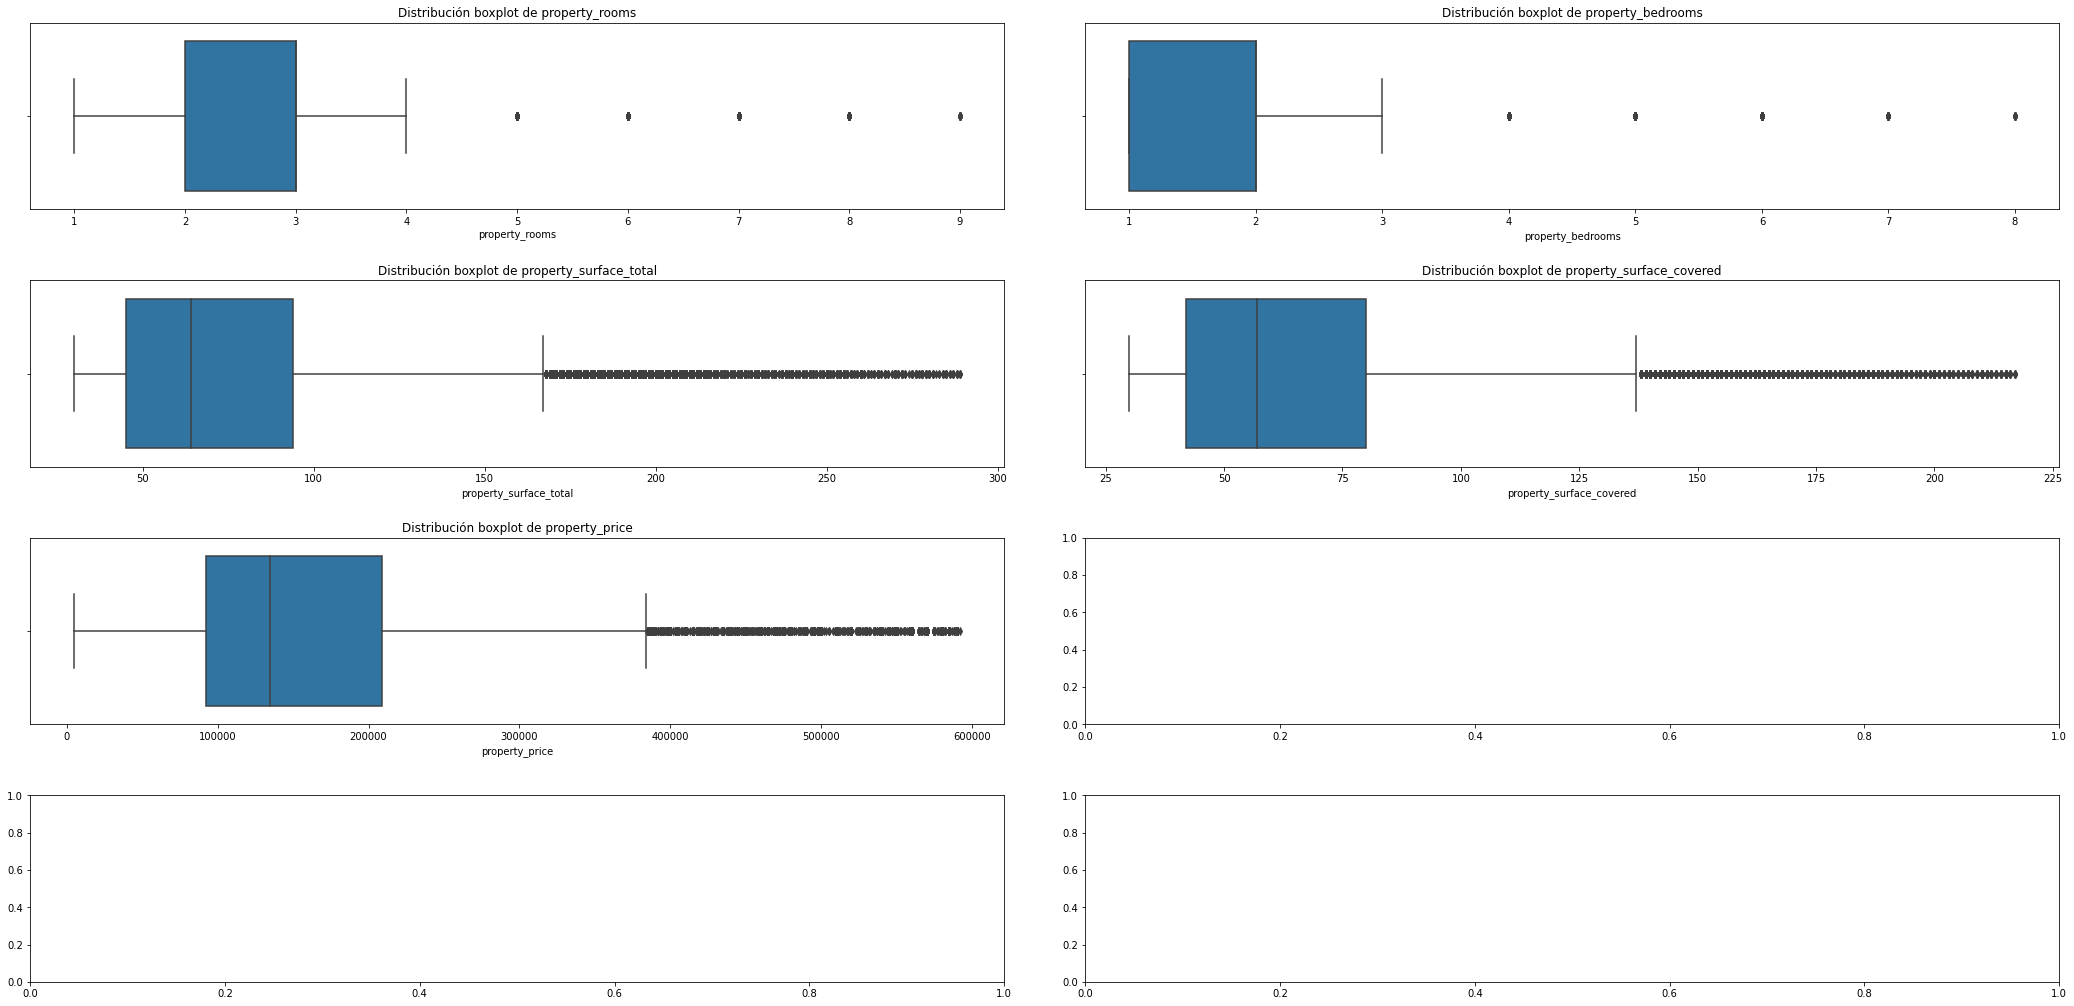

In [74]:
variables_cuantitativas = dataset_train[columnas_cuantitativas]
figs, axes = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))
figs.tight_layout(pad=5)
axes = np.ndarray.flatten(axes)
for (i, columna) in enumerate(variables_cuantitativas.columns):
    grafico = sns.boxplot(ax=axes[i], x=variables_cuantitativas[columna])
    grafico.set(xlabel=columna)
    grafico.set(title=f"Distribución boxplot de {columna}")


Observamos que, si bien las distribuciones mejoraron significativamente, es necesario realizar un análisis más detallado ya que hay algunos casos extraños. Identificamos: el valor de `property_surface_covered` no debería ser mayor que `property_surface_total`, `property_bedrooms` no debería ser mayor a `property_rooms`, entre otros. 

Imprimimos la cantidad de observaciones donde se ven estas anomalías.


In [75]:
print("Cantidad de observaciones con superficie total menor a superficie cubierta: ",
    dataset_train[
        dataset_train.property_surface_total < dataset_train.property_surface_covered
    ].shape[0]
)
print(
    "Cantidad de observaciones con cantidad de dormitorios mayor a cantidad de ambientes: ",
    dataset_train[dataset_train.property_bedrooms > dataset_train.property_rooms].shape[0]
)


Cantidad de observaciones con superficie total menor a superficie cubierta:  91
Cantidad de observaciones con cantidad de dormitorios mayor a cantidad de ambientes:  66


Como no son muchos casos, los eliminamos para poder tener un mejor análisis y que no afecten de forma negativa la imputación.

In [76]:
dataset_train = dataset_train[
    ~(dataset_train.property_surface_covered > dataset_train.property_surface_total)
]
dataset_train = dataset_train[
    ~(dataset_train.property_bedrooms > dataset_train.property_rooms)
]

dataset_test = dataset_test[
    ~(dataset_test.property_surface_covered > dataset_test.property_surface_total)
]
dataset_test = dataset_test[
    ~(dataset_test.property_bedrooms > dataset_test.property_rooms)
]


## Imputación de datos faltantes

Algunas estrategias para imputar los datos faltantes son:

- Sustitución de Casos: Se reemplaza con valores no observados. Hay que consultar con un experto.
- Sustitución por Media: Se reemplaza utilizando la medida calculada de los valores presentes. Sin embargo, esto trae consecuencias
    - La varianza estimada por la nueva variable no es válida ya que es atenuada por los valores repetidos
    - Se distorsiona la distribución
    - Las correlaciones que se observen estarán deprimidas debido a la repetición de un solo valor constante.
- Imputación Cold Deck: Se pueden obtener los datos faltantes a partir de otras variables del dataset.
- Imputacion Hot Deck: Se reemplazan los datos faltante con los valores que resultan más “similares”. Tenemos que definir qué es “similar”, para ello se puede usar la técnica: K vecinos más cercanos.
- Imputación por Regresión: El dato faltante se reemplaza con el valor predicho por un modelo de regresión.
- MICE (multivariate imputation by chained equations): Trabaja bajo el supuesto de que el origen de los datos es MAR (missing at random). Es un proceso de imputación iterativo, donde en cada iteración los valores faltantes se predicen en función de las variables restantes. El proceso se repite hasta que se encuentre consistencia en los datos (usualmente 10 iteraciones es suficiente). La primera iteración se realiza por uno de los métodos vistos anteriormente para rellenar los datos faltantes.

### Imputación de `property_bedrooms`, `property_rooms`, `property_price`

Anteriormente observamos que existe una correlación entre `property_bedrooms`, `property_rooms` y `property_price`. Podemos entrenar un modelo lineal para predecir los datos faltantes.

Imputamos los datos utilizando un imputador iterativo.

In [77]:
columnas_a_imputar = ["property_bedrooms", "property_rooms", "property_price"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    min_value=(1, 1, 50000),
    max_iter=20,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])


def imputar_columnas(modelo, dataset, columnas_a_imputar):
    columnas_imputadas = modelo.transform(dataset[columnas_a_imputar])
    return pd.DataFrame(columnas_imputadas, columns=columnas_a_imputar).astype(int)


dataset_imputado = imputar_columnas(imp, dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(imp, dataset_test, columnas_a_imputar)


Observamos que tienen la misma distribución que los datos originales.

[Text(0.5, 0, 'precio de propiedad (usd)'),
 Text(0.5, 1.0, 'Distribución de precio de propiedad (imputado)')]

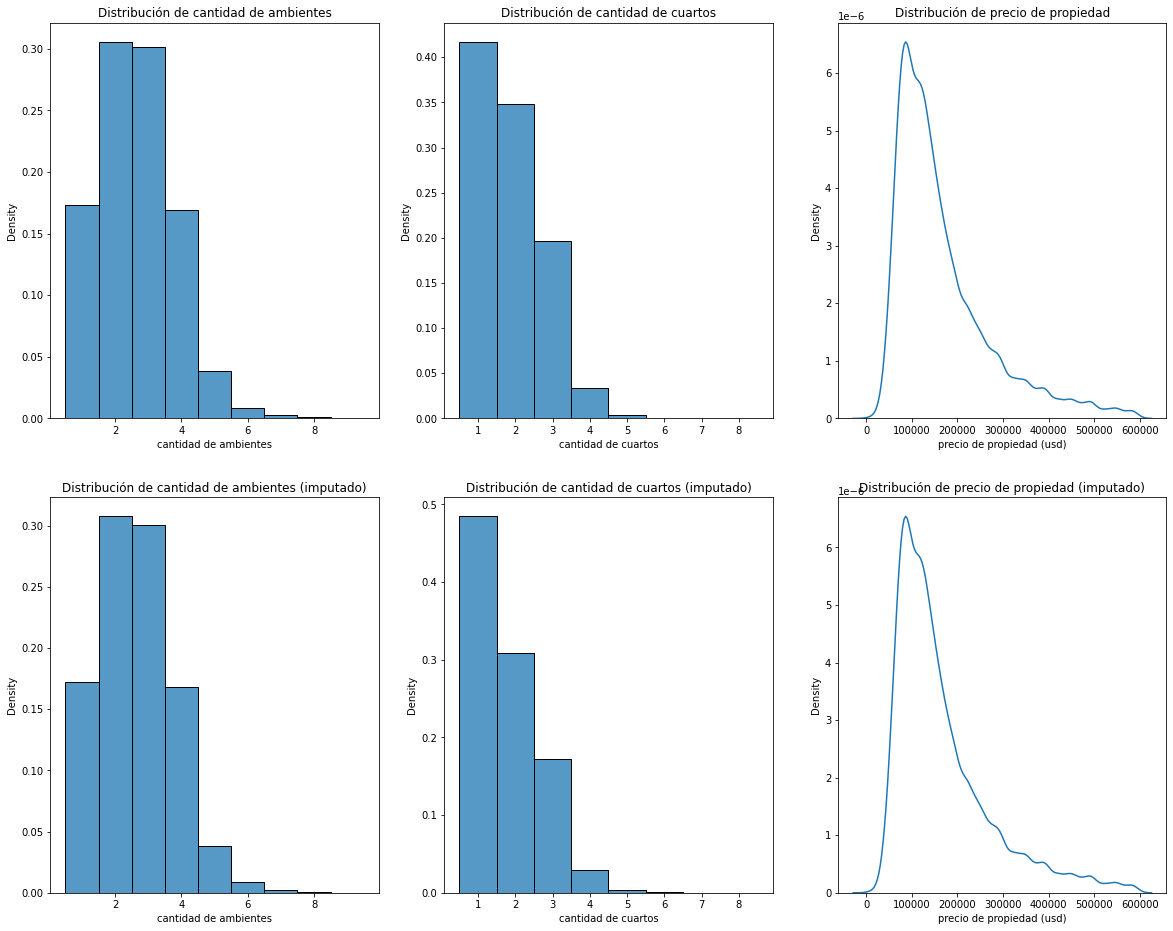

In [78]:
figs, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 16))

ax = sns.histplot(
    ax=axes[0][0], x=dataset_train.property_rooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de ambientes", xlabel="cantidad de ambientes")

ax = sns.histplot(
    ax=axes[0][1], x=dataset_train.property_bedrooms, discrete=True, stat="density"
)
ax.set(title="Distribución de cantidad de cuartos", xlabel="cantidad de cuartos")

ax = sns.kdeplot(ax=axes[0][2], x=dataset_train.property_price)
ax.set(title="Distribución de precio de propiedad", xlabel="precio de propiedad (usd)")

ax = sns.histplot(
    ax=axes[1][0], x=dataset_imputado.property_rooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de ambientes (imputado)",
    xlabel="cantidad de ambientes",
)

ax = sns.histplot(
    ax=axes[1][1], x=dataset_imputado.property_bedrooms, discrete=True, stat="density"
)
ax.set(
    title="Distribución de cantidad de cuartos (imputado)", xlabel="cantidad de cuartos"
)

ax = sns.kdeplot(ax=axes[1][2], x=dataset_imputado.property_price)
ax.set(
    title="Distribución de precio de propiedad (imputado)", xlabel="precio de propiedad (usd)"
)


Actualizamos los valores imputados en el nuevo dataframe y vemos que las columnas imputadas ya no tienen valores faltantes.

In [79]:
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


latitud                     2595
longitud                    2595
barrio                       236
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total      5984
property_surface_covered    6489
property_price                 0
dtype: int64

### Imputación de `property_surface_covered`, `property_surface_total`


También habíamos observado una correlación entre `property_surface_covered`, `property_surface_total` por lo que podemos entrenar otro modelo lineal para predecir estos datos faltantes. 

Imputamos los datos utilizando un imputador iterativo.

In [80]:
columnas_a_imputar = ["property_surface_covered", "property_surface_total"]

modelo_lineal = LinearRegression()
imp = IterativeImputer(
    estimator=modelo_lineal,
    missing_values=np.nan,
    max_iter=20,
    min_value=(30, 30),
    verbose=0,
    random_state=SEMILLA,
)

imp.fit(dataset_train[columnas_a_imputar])

dataset_imputado = imputar_columnas(imp, dataset_train, columnas_a_imputar)
dataset_test_imputado = imputar_columnas(imp, dataset_test, columnas_a_imputar)


Observamos que tienen una distribución parecida a la de los datos originales.

[Text(0.5, 0, 'superficie total (m2)'),
 Text(0.5, 1.0, 'Distribución de superficie total (imputado)')]

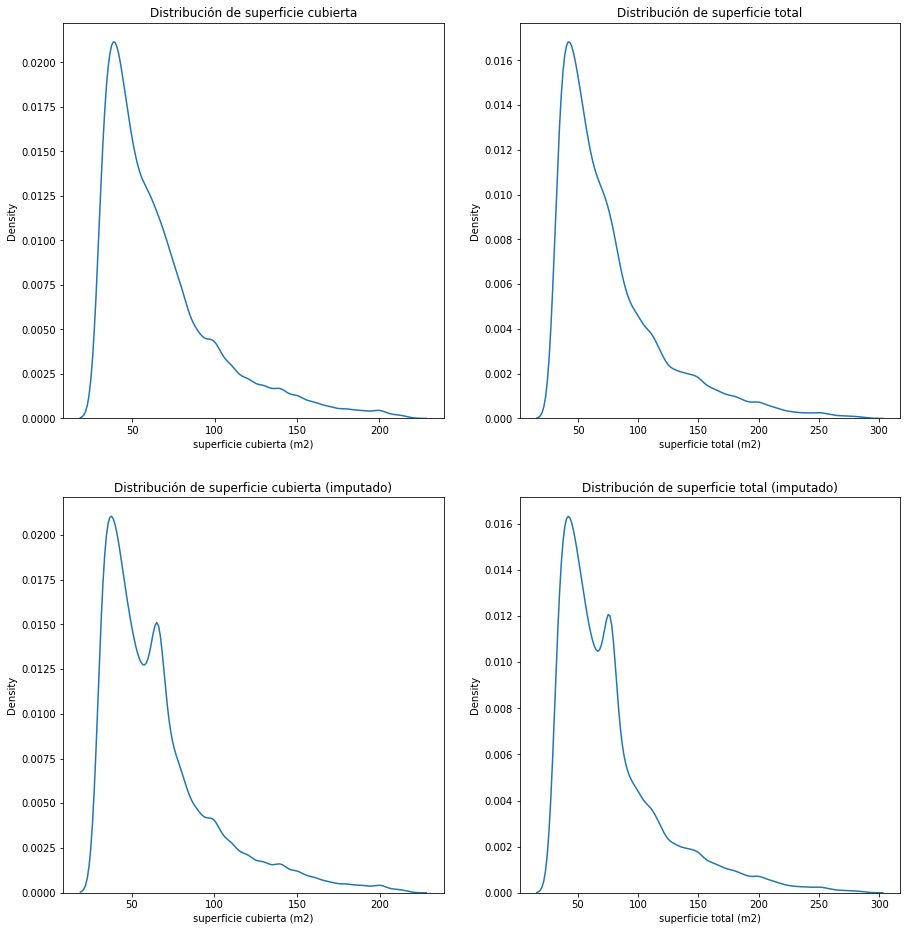

In [81]:
figs, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 16))

ax = sns.kdeplot(ax=axes[0][0], x=dataset_train.property_surface_covered)
ax.set(title="Distribución de superficie cubierta", xlabel="superficie cubierta (m2)")

ax = sns.kdeplot(ax=axes[0][1], x=dataset_train.property_surface_total)
ax.set(title="Distribución de superficie total", xlabel="superficie total (m2)")

ax = sns.kdeplot(ax=axes[1][0], x=dataset_imputado.property_surface_covered)
ax.set(
    title="Distribución de superficie cubierta (imputado)", xlabel="superficie cubierta (m2)"
)

ax = sns.kdeplot(ax=axes[1][1], x=dataset_imputado.property_surface_total)
ax.set(title="Distribución de superficie total (imputado)", xlabel="superficie total (m2)")


Observamos que la distribución es levemente distinta, apareciendo más datos con un valor entre 50 y 100; podemos suponer que sucede porque el modelo realiza una imputación por mediana. 

Actualizamos los valores imputados en el nuevo dataframe y observamos que ahora las columnas imputadas ya no tienen datos nulos.

In [82]:
dataset_train[columnas_a_imputar] = dataset_imputado[columnas_a_imputar].values
dataset_test[columnas_a_imputar] = dataset_test_imputado[columnas_a_imputar].values

dataset_train.isna().sum()


latitud                     2595
longitud                    2595
barrio                       236
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputacion `barrio` por `coordenadas`

Podemos entrenar un modelo que pueda predecir el barrio a partir de las coordenadas.

In [83]:
dataset_forest = dataset_train.copy()
dataset_forest.dropna(inplace=True)

factorizacion_barrio = pd.factorize(dataset_forest["barrio"])
dataset_forest["barrio"] = factorizacion_barrio[0]
definiciones_barrio = factorizacion_barrio[1]

atributos = ["latitud", "longitud"]

target = "barrio"

X = dataset_forest[atributos]
y = dataset_forest[target]

clasificador_rfc = DecisionTreeClassifier(
    random_state=SEMILLA,
)


Separamos en train y test, y escalamos los datos para mayor performance.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEMILLA
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Ahora, entrenamos el modelo y vemos su desempeño

In [85]:
clasificador_rfc.fit(X_train, y_train)
print("Accuracy: ", clasificador_rfc.score(X_test, y_test))

Accuracy:  0.8206680116565792


El desempeño es excelente, lo podemos utilizar para imputar los barrios faltantes. Sin embargo, solo lo podemos aplicar en filas que contengan ambas coordenadas.

In [86]:
def imputar_barrio(fila):
    if fila["barrio"] != None:
        return fila

    if fila[atributos].isna().any():
        return fila

    barrio = clasificador_rfc.predict([fila[atributos].copy()])

    fila["barrio"] = definiciones_barrio[barrio[0]]

    return fila


dataset_train = dataset_train.apply(imputar_barrio, axis=1)
dataset_test = dataset_test.apply(imputar_barrio, axis=1)


Observamos la distribución de faltantes hasta ahora.

In [87]:
dataset_train.isna().sum()


latitud                     2595
longitud                    2595
barrio                       106
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
dtype: int64

### Imputación de `latitud`, `longitud` según `barrio`

Primero, buscamos el punto medio de cada barrio, para luego reemplazarlo en las coordenadas faltantes.

In [88]:
columnas_ubicacion = ["latitud", "longitud", "barrio"]
dataset_ubicaciones = dataset_train[columnas_ubicacion]
promedio_ubicaciones = dataset_ubicaciones.groupby("barrio").mean()


Ahora, podemos reemplazar los datos de latitud y longitud faltantes con el promedio para el barrio al que pertenecen.

In [89]:
def imputar_cordenada(fila):
    barrio = fila["barrio"]

    if barrio == None:
        return fila

    if np.isnan(fila["latitud"]):
        fila["latitud"] = promedio_ubicaciones.at[barrio, "latitud"]

    if np.isnan(fila["longitud"]):
        fila["longitud"] = promedio_ubicaciones.at[barrio, "longitud"]

    return fila


dataset_train = dataset_train.apply(imputar_cordenada, axis=1)
dataset_test = dataset_test.apply(imputar_cordenada, axis=1)


Observamos la distribución de datos faltantes.

In [90]:
dataset_train.isna().sum()


latitud                     106
longitud                    106
barrio                      106
property_type                 0
property_rooms                0
property_bedrooms             0
property_surface_total        0
property_surface_covered      0
property_price                0
dtype: int64

### Datos Faltantes Restantes

Finalmente, tenemos una cantidad muy baja de valores faltantes en la ubicación. Los podemos quitar para facilitar los análisis posteriores.

In [91]:
dataset_train = dataset_train[~dataset_train.barrio.isna()]
dataset_test = dataset_test[~dataset_test.barrio.isna()]


In [92]:
dataset_train.isna().sum()


latitud                     0
longitud                    0
barrio                      0
property_type               0
property_rooms              0
property_bedrooms           0
property_surface_total      0
property_surface_covered    0
property_price              0
dtype: int64

## Análisis de Valores Atípicos Multivariados

Al intentar aplicar la medida de distancia Mahalanobis el algoritmo no funcionaba ya que multiplicar matrices de dimensiones tan altas requería de una cantidad de memoria RAM demasiado grande. Por otro lado, el algoritmo LOF tampoco funcionaba del todo bien ya que la información no está ordenada en clusters, por lo que los cálculos de densidad no daban bien. Debido a esto, decidimos aplicar `IsolationForest` para analizar la presencia de valores atípicos multivariados.  

### Isolation Forest para `property_surface_total` y `property_price`

Ahora vamos a analizar la distribución de valores atipicos en únicamente las columnas `property_surface_total` y `property_price`.

Graficamos la distribución de estas variables en un **scatter plot**.

[Text(0, 0.5, 'property price (usd)'),
 Text(0.5, 0, 'property surface total (m^2)'),
 Text(0.5, 1.0, 'Distribución de superficie total vs precio')]

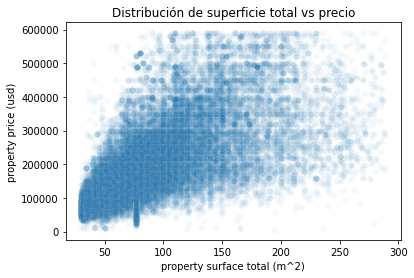

In [93]:
sns.scatterplot(
    data=dataset_train, x="property_surface_total", y="property_price", alpha=0.05
).set(title = "Distribución de superficie total vs precio", xlabel="property surface total (m^2)", ylabel="property price (usd)")


Observamos que hay mucha concentración, con algunas observaciones dispersas. Realizamos otro `isolation forest` para identificarlas. 

Notamos también una concentración de valores entre 50 y 100, lo que seguramente se debe al cambio en la distribución que se observó en la imputación de `property_surface_total`.

In [94]:
columnas = [
    "property_surface_total",
    "property_price",
]

dataset_isolation_forest = dataset_train[columnas].copy()
n_samples = dataset_isolation_forest.shape[0] // 4

iforest = IsolationForest(
    n_estimators=100,
    max_samples=n_samples,
    contamination=0.005,
    max_features=len(columnas),
    bootstrap=True,
    n_jobs=-1,
    random_state=SEMILLA,
)

dataset_isolation_forest["outlier"] = iforest.fit_predict(dataset_isolation_forest)
dataset_isolation_forest["outlier"] = dataset_isolation_forest["outlier"].replace(
    to_replace=[-1, 1], value=[True, False]
)

print("Cantidad de observaciones anómalas:")
print(dataset_isolation_forest["outlier"].value_counts())


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


Cantidad de observaciones anómalas:
False    69185
True       348
Name: outlier, dtype: int64


Graficamos la distribución de outliers encontrada.

[Text(0, 0.5, 'property price (usd)'),
 Text(0.5, 0, 'property surface total (m^2)'),
 Text(0.5, 1.0, 'Distribución de superficie total vs precio')]

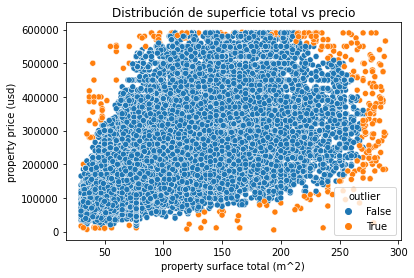

In [96]:
sns.scatterplot(
    data=dataset_isolation_forest,
    x="property_surface_total",
    y="property_price",
    hue="outlier",
).set(title = "Distribución de superficie total vs precio", xlabel="property surface total (m^2)", ylabel="property price (usd)")

Observamos que marca pocos valores que en el gráfico se aprecian como atípicos (por ejemplo, `property_surface_total` alto con `property_price` bajo) por lo que los quitamos para continuar el análisis.

In [97]:
dataset_train = dataset_train[~dataset_isolation_forest.outlier]


Observamos la forma de nuestro `dataset_train`, luego del preprocesamiento. Luego de las imputaciones y eliminación de los outliers y datos faltantes que no se pudieron imputar tenemos el dataset que se utilizará para entrenar modelos y realizar predicciones.

In [98]:
dataset_train.shape


(69185, 9)

### Exportacion

Exportamos los datasets luego de aplicar el preprocesamiento de datos.

In [99]:
dataset_train.to_csv("properati_argentina_2021_train_preprocesado.csv")
dataset_test.to_csv("properati_argentina_2021_test_preprocesado.csv")